## Part 2

In [157]:
import tensorflow as tf
import datetime, os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder, normalize, scale
from sklearn import svm
from sklearn.utils import resample
from datetime import datetime
import seaborn as sns
from joblib import load
from scipy.stats import mode
from collections import defaultdict
from scipy.stats import norm

In [158]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


In [81]:
seed = 101

np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.set_random_seed(seed)

### Load Models

In [82]:
model_dtc = load("train/dtc_max_features=8_max_depth=4_min_sample_split_5_min_samples_leaf_11_20210704-174343.pkl")
model_svm = load("train/svm_C=25_kernel=linear_20210704-174344.pkl")
model_nb = load("train/naive_bayers_Age+Fare+SibSp+Parch+Class_Middle+Class_Upper+Port_C+Port_Q+passenger_sex.pkl")
model_lr = load("train/linear_reg_lr_0.01_batch_size_32_epochs_1000_lmbda_0_method_lasso.pkl")


In [83]:
model_dtc

DecisionTreeClassifier(max_depth=4, max_features=8)

In [84]:
model_svm

SVC(C=25, kernel='linear')

In [85]:
model_nb

[{'continous': {0:                    mean        sd    n
   Age            0.819279  0.231927  355
   Fare           0.457828  0.253432  355
   SibSp          0.013765  0.029795  355
   Parch          0.007437  0.018998  355
   Class_Middle   0.177465  0.382601  355
   Class_Upper    0.146479  0.354085  355
   Port_C         0.123944  0.329982  355
   Port_Q         0.092958  0.290783  355
   passenger_sex  0.842254  0.365018  355,
   1:                    mean        sd    n
   Age            0.628314  0.312913  213
   Fare           0.656879  0.273829  213
   SibSp          0.012427  0.023386  213
   Parch          0.014678  0.027112  213
   Class_Middle   0.267606  0.443754  213
   Class_Upper    0.375587  0.485415  213
   Port_C         0.262911  0.441251  213
   Port_Q         0.098592  0.298815  213
   passenger_sex  0.342723  0.475738  213},
  'discrete': defaultdict(dict, {}),
  'prob_y': 0    0.625
  1    0.375
  Name: passenger_survived, dtype: float64,
  'config': {'categor

In [86]:
model_lr

array([[ 3.1078911e-01],
       [-5.8883584e-01],
       [ 1.9080630e-01],
       [ 6.5132225e-01],
       [ 1.2965122e-01],
       [ 2.1791285e-01],
       [-8.4733233e-02],
       [-3.2443084e-05],
       [-7.5815055e-06],
       [ 3.3288529e-06],
       [ 9.7460836e-01],
       [-2.0967753e+00]], dtype=float32)

### Predict 

In [168]:
def build_naive_bayes(summaries):
    categorical = summaries["config"]["categories"]
    continous = summaries["config"]["continous"]
    continous_prob = summaries["continous"]
    discrete_prob = summaries["discrete"]
    prob_y = summaries["prob_y"]
    def predict_prob(newdata):
        prob = []
        for out in prob_y.index.values:
            prob_cont = np.stack([norm(continous_prob[out].iloc[col,:]["mean"], continous_prob[out].iloc[col,:]["sd"]).cdf(newdata[:,col]) for col in range(len(continous))], axis=1) if continous else np.ones((newdata.shape[0],1))
            prob_disc = np.stack([discrete_prob[out][col][newdata[:,col]] for col in range(len(categorical))], axis=1) if categorical else np.ones((newdata.shape[0],1))
            prob.append(np.prod((np.concatenate([prob_cont, prob_disc], axis=1)), axis=1) * prob_y[out])
        return np.stack(prob, axis=1)
    return lambda newdata: np.argmax(predict_prob(newdata), axis=1), predict_prob

predict_nb, predict_prob_nb = build_naive_bayes(model_nb[0])

In [161]:
def compute_logits(X, params):
    ## add a column of one's to add the bias (b) in the same vectorize operation
    with tf.name_scope("Logits"):
        padding = tf.constant([[0,0],[1, 0]], name="Padding")
        X_with_bias = tf.pad(X, padding, "CONSTANT", constant_values=1, name="PreparedData")
        logits = tf.linalg.matmul(X_with_bias, params, name="Logits")
    return logits

def build_predict(params):
    return lambda x: tf.round(tf.nn.sigmoid(compute_logits(x, params), name="Model"))

def build_predict_prob(params):
    return lambda x: tf.nn.sigmoid(compute_logits(x, params), name="Model")

def build_predict_lreg(params):
    def predict_lreg(x_test):
        tensor_x_test = tf.placeholder(tf.float32, [None,x_test.shape[1]], name="X_test")
        get_predictions = build_predict(params)(tensor_x_test)
        get_probabilities = build_predict_prob(params)(tensor_x_test)
        with tf.Session() as session:
            y_hat_val, probs= session.run([get_predictions, get_probabilities], feed_dict = { tensor_x_test: x_test})
        return y_hat_val, probs
    return predict_lreg

predict_linear_reg = build_predict_lreg(model_lr)

In [166]:
def predict_survived(x_test):
    y_hat_dtc = model_dtc.predict(x_test)
    y_hat_svm = model_svm.predict(x_test)
    y_hat_test_nb = predict_nb(x_test)
    y_hat_lreg, _ = predict_linear_reg(x_test)
    predictions = np.stack((y_hat_dtc, y_hat_svm, y_hat_test_nb, y_hat_lreg.reshape(-1)), axis=1)
    return mode(predictions, axis=1)[0]

In [90]:
x_test = load('x_test.pkl')
y_test = load('target_test.pkl')

In [91]:
x_test = x_test.drop(columns=["Embarked", "passenger_class", "has_fam"])
x_test.head()

,Class_Lower,Class_Middle,Class_Upper,Port_C,Port_Q,Port_S,Age,SibSp,Parch,Fare,passenger_sex
31,0,0,1,1,0,0,0.187698,0.006704,0.000000,0.982204,0
674,0,1,0,0,0,1,1.000000,0.000000,0.000000,0.000000,1
661,1,0,0,1,0,0,0.984076,0.000000,0.000000,0.177749,1
859,1,0,0,1,0,0,0.968249,0.000000,0.000000,0.249988,1
233,1,0,0,0,0,1,0.155781,0.124625,0.062312,0.977915,0


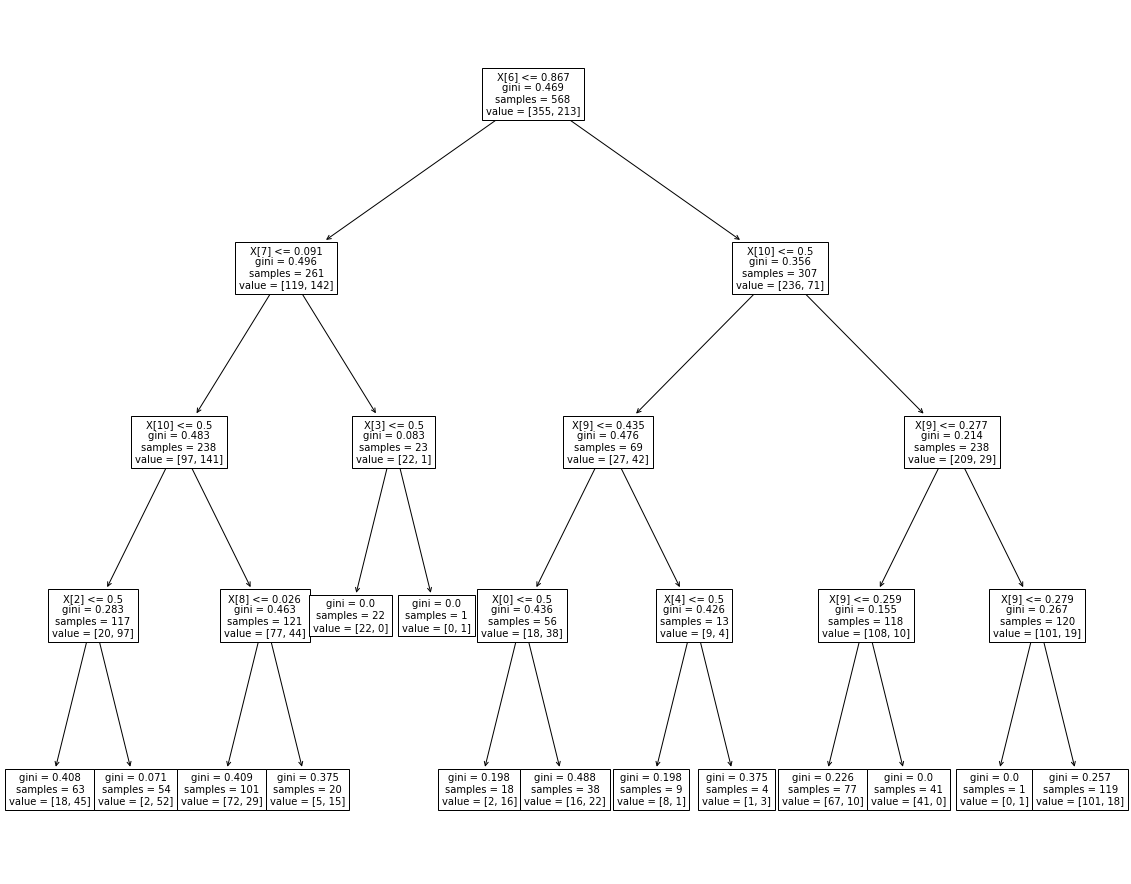

In [142]:
plt.figure(figsize=(20,16))  
tree.plot_tree(model_dtc, fontsize=10)
plt.show()

In [154]:
## Salida probabilistica Bayes y = 0 , y = 1
predict_prob_nb(x.to_numpy())

array([[1.98199233e-09, 4.14722667e-07],
       [2.96789585e-08, 1.83694312e-05],
       [2.38407423e-06, 4.01037365e-06],
       [2.42118170e-06, 4.83064068e-06],
       [2.81874295e-06, 4.39618607e-06],
       [2.10103526e-09, 4.03876906e-07],
       [2.41817958e-06, 4.79850081e-06],
       [1.57756943e-09, 2.65634394e-07],
       [2.53485936e-06, 4.06909918e-06],
       [1.76611250e-09, 3.08656047e-07]])

In [162]:
## Linear Regression Probabilieites

y_hat_lreg, prob = predict_linear_reg(x.to_numpy())
prob

array([[0.22803685],
       [0.22344142],
       [0.119039  ],
       [0.10062543],
       [0.1707798 ],
       [0.8258009 ],
       [0.10705361],
       [0.85639405],
       [0.13941607],
       [0.4105799 ]], dtype=float32)

### Test 10 samples

In [176]:

x, y = resample(x_test, y_test, n_samples = 10)

for i, row in x.iterrows():
    print(i, predict_survived(row.to_numpy().reshape(1,-1))[0][0])
print(y)

197 0.0
416 1.0
815 0.0
694 0.0
506 1.0
601 0.0
541 1.0
334 1.0
261 0.0
143 0.0
197    0
416    1
815    0
694    0
506    1
601    0
541    0
334    1
261    1
143    0
Name: passenger_survived, dtype: int64
